### Gaussian pulse moving through dielectric $\varepsilon$ barriers

Based on the work presented in Alfonso Barba's thesis: https://oa.upm.es/35284/1/ALFONSO_BARBAS_ESPA.pdf 

In the 1D example shown in Figure 2.9, a gaussian wave-packet is transmitted and reflected at 3 consecutive dielectric barriers:

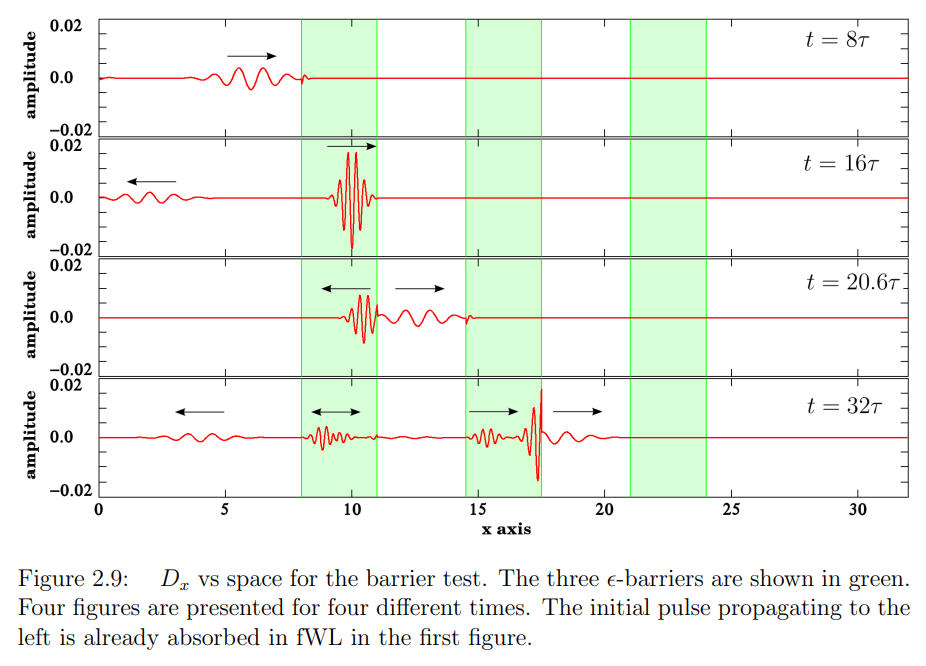

The energy of the pulse propagating in positive and negative directions is designated +/- depending on the propagation direction right/left respectively:

$$u = \frac{1}{2}\left( \varepsilon |E|^2 + \mu |H|^2  \right) = u^+ + u^-$$

In Figure 2.10, the energy evolution of the simulation is shown (note that Q == u in the nomenclature chosen for this notebook): 

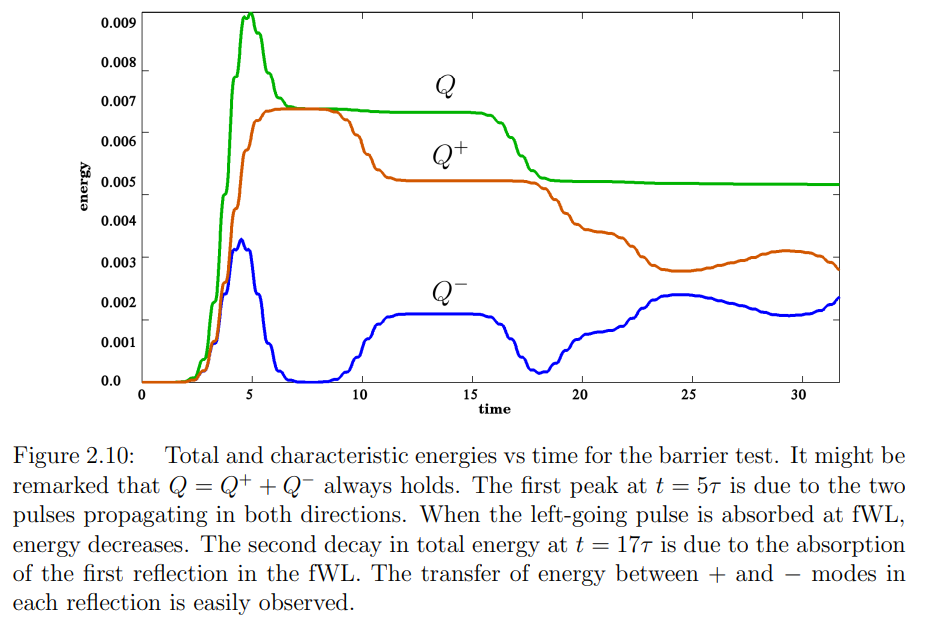

## Simulation with wakis
----

In [1]:
from scipy.constants import c as c_light
import numpy as np
from tqdm import tqdm

# import wakis package (local)
import sys
sys.path.append('../wakis/')

from wakis.solverFIT3D import SolverFIT3D
from wakis.gridFIT3D import GridFIT3D
from wakis.sources import WavePacket

# import wakis package from pip
# from wakis import SolverFIT3D, GridFIT3D
# from wakis.sources import WavePacket

# Plotting settings
import pyvista as pv
import matplotlib.animation
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

%matplotlib ipympl

### Domain definition

In [2]:
# Barriers
barrier = {}
barrier[1] = pv.Cube(x_length=5, y_length=5, center=(0,0,3)) #1x1x1 m
barrier[2] = pv.Cube(x_length=5, y_length=5, center=(0,0,5))
barrier[3] = pv.Cube(x_length=5, y_length=5, center=(0,0,7))
barriers = barrier[1] + barrier[2] + barrier[3]

barriers.save('barriers.stl')
#barriers.plot()

In [ ]:
# Number of mesh cells
Nx = 50
Ny = 50
Nz = 150

# Stl input
stl_solids = {'barriers' : 'barriers.stl'}
stl_materials = {'barriers' : [5.0, 1.0]} #[eps, mu]

# Domain bounds
print(barriers.bounds)
xmin, xmax, ymin, ymax, zmin, zmax = barriers.bounds
zmin, zmax = 0., 10.

# Simulation grid
grid = GridFIT3D(xmin, xmax, ymin, ymax, zmin, zmax, 
                 Nx, Ny, Nz, 
                 stl_solids=stl_solids, 
                 stl_materials=stl_materials)
#grid.inspect()

### Solver setup

In [ ]:
# boundary conditions
bc_low=['periodic', 'periodic', 'pec']  
bc_high=['periodic', 'periodic', 'pec']

solver = SolverFIT3D(grid=grid,     # pass grid object
                     cfln=0.5,       # Default if no dt is defined
                     bc_low=bc_low, 
                     bc_high=bc_high, 
                     use_stl=True,     # Enables or disables geometry import
                     bg='vacuum',      # Background material 
                     )


In [ ]:
solver.ieps.inspect()

### Source setup

In [ ]:
# Add Gaussian wavepacket
source = WavePacket(xs=slice(0,Nx), ys=slice(0,Ny),
                    sigmaxy=0.7,
                    sigmaz=0.5,
                    wavelength=0.75,
                    tinj=3)

t = np.arange(0,2000*solver.dt, solver.dt)
source.plot(t)

# plot 2d
X, Y = np.meshgrid(solver.x, solver.y)
gaussxy = np.exp(-(X**2+Y**2)/(2*source.sigmaxy**2))
plt.figure()
plt.contourf(X,Y,gaussxy)

### Time-stepping

In [ ]:
solver.E.inspect()
solver.H.inspect()

In [8]:
def energy(solver):
    E2 = solver.E.get_abs()**2
    H2 = solver.H.get_abs()**2   
    eps = 1/solver.ieps.get_abs()
    mu = 1/solver.imu.get_abs() 

    return 0.5*(eps*E2 + mu*H2)

In [ ]:
#initialize to 0
for d in ['x','y','z']:
    solver.E[:,:,:,d] = 0.
    solver.H[:,:,:,d] = 0.


Hy, U = {}, {}
plot2D=False
N1 = 2*int((zmax-zmin)/c_light/solver.dt)
for n in tqdm(range(N1)):

    #apply source
    source.update(solver, solver.dt*n)

    #Advance fields
    solver.one_step()

    if n%30 == 0:
        Hy[n] = solver.H[Nx//2, Ny//2, :, 'y']
        U[n] = np.sum(energy(solver))

    if plot2D and n%50 == 0:
        solver.plot2D(field='H', component='y', plane='ZY', pos=0.5, norm='symlog', 
               vmin=-1, vmax=1, figsize=[8,4], cmap='RdBu', patch_alpha=0.1, 
               add_patch=None, title='Hy', off_screen=True, n=n, interpolation='spline36')
    

### Plot and animate results

In [ ]:
# quick plotting
solver.plot1D('Hy', pos=0.5)

In [ ]:
# frames animation
fig, ax = plt.subplots(figsize=[8,3])

def animate(frame):
    plt.cla()

    # field
    t = list(Hy.keys())
    plt.plot(solver.z, Hy[t[frame]], c='r')
    plt.ylim((-1, 1))
    plt.xlim((0,10))
    
    # barriers
    for b in barrier.values():
        xlo, xhi, ylo, yhi, zlo, zhi = b.bounds
        plt.axvspan(zlo, zhi, color='g', alpha=0.3)

    plt.xlabel('z [m]')
    plt.ylabel('Magnetic field Hy [A/m]')

anim = matplotlib.animation.FuncAnimation(fig, animate, frames=len(Hy.keys()))
anim.save(f'dielectric_barriers.gif')
plt.close(fig)

In [ ]:
# plot of the energy
plt.figure()
plt.plot(np.array(list(U.keys()))*solver.dt, list(U.values()), '-ob')
plt.xlim(0,N1*solver.dt)
plt.ylabel('Total Energy <U>', c='b')
plt.xlabel('Time [s]')
plt.title(r'Total energy <U>$= \frac{1}{2}\left( \varepsilon |E|^2 + \mu |H|^2  \right)$')